In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
import statsmodels.stats.api as sms

In [2]:
sns.set_theme()

In [3]:
df = pd.read_csv('referral.csv')

In [12]:
df['date'] = pd.to_datetime(df['date'])

In [13]:
df.head()

,user_id,date,country,money_spent,is_referral,device_id
0,2,2015-10-03,FR,65,0,EVDCJTZMVMJDG
1,3,2015-10-03,CA,54,0,WUBZFTVKXGQQX
2,6,2015-10-03,FR,35,0,CBAPCJRTFNUJG
3,7,2015-10-03,UK,73,0,PRGXJZAJKMXRH
4,7,2015-10-03,MX,35,0,PRGXJZAJKMXRH


# Exploratory data analysis

## Referral tags

In [7]:
df[df['date']<'2015-10-31']['is_referral'].value_counts()

0    47341
Name: is_referral, dtype: int64

In [5]:
df[df['date']>='2015-10-31']['is_referral'].value_counts()

1    28017
0    21983
Name: is_referral, dtype: int64

Users with different referral tags

In [12]:
df.groupby('user_id')['is_referral'].nunique().sort_values(ascending=False).head(5)

user_id
9776     2
12026    2
11988    2
11990    2
11991    2
Name: is_referral, dtype: int64

In [13]:
df[df['user_id']==11991]

,user_id,date,country,money_spent,is_referral,device_id
49297,11991,2015-10-31,FR,12,0,UIVVAMTPJQHSN
52412,11991,2015-11-01,FR,28,1,UIVVAMTPJQHSN
59359,11991,2015-11-06,US,44,1,UIVVAMTPJQHSN
86762,11991,2015-11-21,IT,20,1,UIVVAMTPJQHSN
96851,11991,2015-11-27,ES,18,1,UIVVAMTPJQHSN


Change the referral tag into the first one

In [14]:
df.sort_values('date', inplace=True)

In [6]:
df['is_referral'] = df.groupby('user_id')['is_referral'].transform('first')

## Transaction pattern

Text(0, 0.5, 'customer numbers')

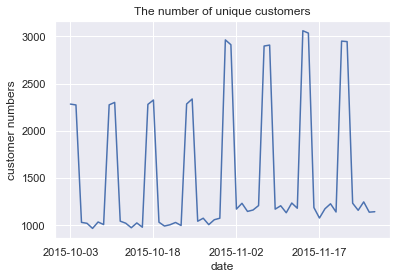

In [32]:
plt.plot(df.groupby('date')['user_id'].nunique())

tick_locations = list(range(0, 60, 15))
plt.xticks(ticks=tick_locations)

plt.title('The number of unique customers')
plt.xlabel('date')
plt.ylabel('customer numbers')

## Revenue

Text(0, 0.5, 'Revenue')

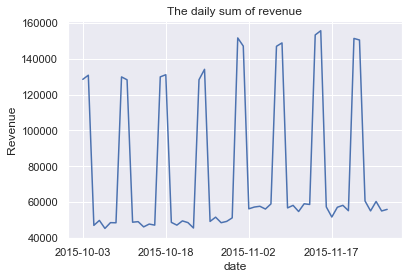

In [31]:
plt.plot(df.groupby('date')['money_spent'].sum())

tick_locations = list(range(0, 60, 15))
plt.xticks(ticks=tick_locations)

plt.title('The daily sum of revenue')
plt.xlabel('date')
plt.ylabel('Revenue')

# Effects of referral program

## Performance after program

Create aggregated df

In [41]:
df_g = df.groupby(['date', 'is_referral']).agg(user_cnt=('user_id', 'nunique'), 
                                               money_sum=('money_spent', 'sum')).reset_index()

df_g['money_user'] = df_g['money_sum']/df_g['user_cnt']

In [37]:
df_g.head(10)

,date,is_referral,user_cnt,money_sum,money_user
0,2015-10-03,0,2283,128475,56.274639
1,2015-10-04,0,2274,130772,57.507476
2,2015-10-05,0,1030,46946,45.578641
3,2015-10-06,0,1020,49711,48.736275
4,2015-10-07,0,966,45242,46.834369
5,2015-10-08,0,1034,48463,46.869439
6,2015-10-09,0,1007,48389,48.052632
7,2015-10-10,0,2275,129837,57.071209
8,2015-10-11,0,2301,128229,55.727510
9,2015-10-12,0,1043,48712,46.703739


Text(0, 0.5, 'customer numbers')

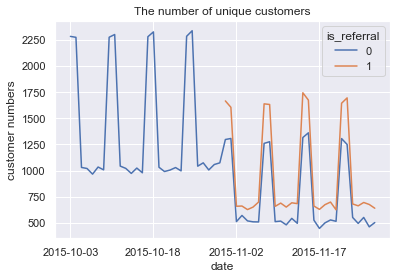

In [38]:
sns.lineplot(data=df_g, x='date', y='user_cnt', hue='is_referral')

tick_locations = list(range(0, 60, 15))
plt.xticks(ticks=tick_locations)

plt.title('The number of unique customers')
plt.xlabel('date')
plt.ylabel('customer numbers')

- Cannibalization : The new feature is taking away existing customers from another source

Text(0, 0.5, 'Revenue')

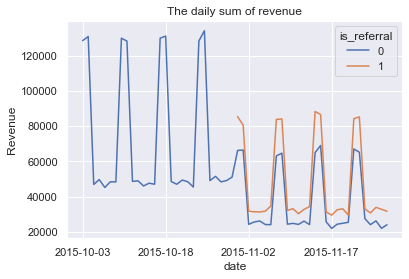

In [43]:
sns.lineplot(data=df_g, x='date', y='money_sum', hue='is_referral')

tick_locations = list(range(0, 60, 15))
plt.xticks(ticks=tick_locations)

plt.title('The daily sum of revenue')
plt.xlabel('date')
plt.ylabel('Revenue')

Text(0, 0.5, 'Revenue')

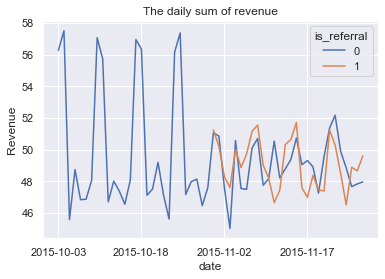

In [44]:
sns.lineplot(data=df_g, x='date', y='money_user', hue='is_referral')

tick_locations = list(range(0, 60, 15))
plt.xticks(ticks=tick_locations)

plt.title('The daily sum of revenue')
plt.xlabel('date')
plt.ylabel('Revenue')

## Check device ID

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'numbers')

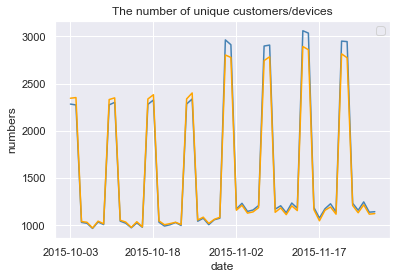

In [48]:
plt.plot(df.groupby('date')['user_id'].nunique(), color='steelblue')
plt.plot(df.groupby('date')['device_id'].nunique(), color='orange')

tick_locations = list(range(0, 60, 15))
plt.xticks(ticks=tick_locations)

plt.title('The number of unique customers/devices')
plt.xlabel('date')
plt.ylabel('numbers')

- different users are sharing the same device
- hard to estimate the impact the program had on the site. Data is way to messy to estimate that reliably

# Time series model

In [4]:
from prophet import Prophet

In [5]:
df.head()

,user_id,date,country,money_spent,is_referral,device_id
0,2,2015-10-03,FR,65,0,EVDCJTZMVMJDG
1,3,2015-10-03,CA,54,0,WUBZFTVKXGQQX
2,6,2015-10-03,FR,35,0,CBAPCJRTFNUJG
3,7,2015-10-03,UK,73,0,PRGXJZAJKMXRH
4,7,2015-10-03,MX,35,0,PRGXJZAJKMXRH


## Data preparation

In [14]:
df_pre = df[df['date']<'2015-10-31'].groupby('date')['money_spent'].sum().reset_index()

df_pre['ds'] = df_pre['date']
df_pre.rename(columns = {'money_spent':'y'}, inplace=True)
df_pre.set_index('date', inplace=True)

In [15]:
ts = Prophet(interval_width=0.95)
ts.fit(df_pre)

12:04:39 - cmdstanpy - INFO - Chain [1] start processing
12:04:39 - cmdstanpy - INFO - Chain [1] done processing


## Model results

In [18]:
period = (df['date'].max() - df_pre['ds'].max()).days

df_future = ts.make_future_dataframe(periods=period)
predictions = ts.predict(df_future)

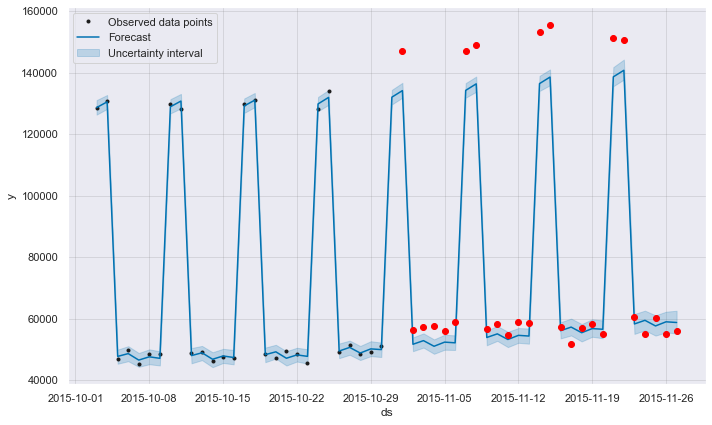

In [22]:
ts.plot(predictions)
plt.plot(df[df['date']>'2015-10-31'].groupby('date')['money_spent'].sum(), 'o', color='red')

plt.legend()

- actual values tend to be fairly consistently above our predictions, often well above the 95% interval of the prediction

## Difference test

In [34]:
print('Average of actual results:', df[df['date']>='2015-10-31'].groupby('date')['money_spent'].sum().mean())
print('Average of prediction:', predictions[predictions['ds']>='2015-10-31']['yhat'].mean())

Average of actual results: 83714.39285714286
Average of prediction: 78460.53910428242


### T-test

In [42]:
g0 = df[df['date']>='2015-10-31'].groupby('date')['money_spent'].sum()
g1 = predictions[predictions['ds']>='2015-10-31']['yhat']

# t-test day by day
ttest = stats.ttest_rel(g0, g1)

In [43]:
ttest

Ttest_relResult(statistic=4.126721249987595, pvalue=0.0003162617753735657)